# Exploratory Analysis for Bridge Conditions


### Contents

1.  Introduction
  1. Object and Outline
  1. Data loading
  1. Data Preparation

2. Exploratory Analysis
  1. Distributions of the numerical values
  2. Correlation of the numerical values
  3. Relationship of the categorical variables to the condition variables
  4. Relationship between categorical variables
   
3. Regression analysis
  1. Dummy Variables Transformation
  2. Regression Fit and Coefficients
  3. Analysis of Residuals

4. Conclusions


## Section 1: Introduction

### Section 1.1 Objective and Outline
The objective of this analysis is to investigate of which of the five variables:
 1. age
 2. average use
 3. percent trucks
 4. material
 5. design 

have more influence on the current condition of the bridges in Texas. 

This section prepares the data. In section 1.2 we load the data and select the variables of interest. In section 1.3, we prepare the data for further analysis. 

Section 2 is an exploratory analysis of the relationships between the proposed predictors and the condition. The linear model is in Section 3 and conclusions are in the final section.

### Section 1.2 Loading the Data 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns   # this is an additional plotting library
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

#import statsmodels.api as sm

We then read the dataset that is going to be used for the analysis, including just the variables needed for this analysis.

In [2]:
# The code below declares a catageorical type with categories in a specified order
# This can be used for an ordinal variable
rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

# This one is also for an rdinal variable, but with a slightly different set of values
scour_type = pd.CategoricalDtype(
    categories=['Unknown', 'Critical','Unstable', 'Stable', 'Protected', 'Dry', 'No waterway'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':scour_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id', 
                      usecols=['Structure_id', 'Year', 'AverageDaily', 'Trucks_percent','Historic','Material','Design',
                               'Deck_rating', 'Superstr_rating', 'Substr_rating'])

bridges  # uncomment to preview the data

,Year,AverageDaily,Historic,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Trucks_percent
Structure_id,,,,,,,,,
000021521-00101,2005,1,Not historic,Concrete,Slab,Good,Very Good,Very Good,0.0
000021521-00181,2005,1,Not historic,Concrete,Slab,Good,Good,Very Good,0.0
000021521-TMP20,2012,100,Not historic,Concrete,Beam,Very Good,Very Good,Very Good,0.0
000021525-00012,1950,80,Not historic,Timber,Beam,Good,Good,Poor,0.0
000021580-00092,2004,150,Not historic,Concrete,Beam,Good,Very Good,Very Good,4.0
...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,Not historic,Concrete,Beam,Good,Good,Good,40.0
DAPFORHOO000013,2000,300,Not historic,Concrete,Beam,Good,Good,Good,40.0
DAPFORHOO000015,1996,1200,Not historic,Concrete,Beam,Good,Good,Good,25.0


**Null Values**
We can check for null values. We note that there are a small number of null values of `Deck_rating` (5) and `Superstr_rating` (2). We exclude these bridges - 7 in all. 

In [3]:
bridges.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34293 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             34293 non-null  int64   
 1   AverageDaily     34293 non-null  int64   
 2   Historic         34293 non-null  category
 3   Material         34293 non-null  category
 4   Design           34293 non-null  category
 5   Deck_rating      34288 non-null  category
 6   Superstr_rating  34291 non-null  category
 7   Substr_rating    34293 non-null  category
 8   Trucks_percent   34293 non-null  float64 
dtypes: category(6), float64(1), int64(2)
memory usage: 1.2+ MB


In [4]:
bridges1 = bridges.dropna()
bridges1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34286 entries, 000021521-00101 to DAPTRABLI000011
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Year             34286 non-null  int64   
 1   AverageDaily     34286 non-null  int64   
 2   Historic         34286 non-null  category
 3   Material         34286 non-null  category
 4   Design           34286 non-null  category
 5   Deck_rating      34286 non-null  category
 6   Superstr_rating  34286 non-null  category
 7   Substr_rating    34286 non-null  category
 8   Trucks_percent   34286 non-null  float64 
dtypes: category(6), float64(1), int64(2)
memory usage: 1.2+ MB


**Unknown Ratings** 
We also need to exclude bridges in which any of the ratings are unknown. We check and find that there are none.


In [5]:
bridges1.loc[(bridges1.Deck_rating == 'NA') | (bridges1.Superstr_rating == 'NA') | 
             (bridges1.Substr_rating == 'NA') ]

,Year,AverageDaily,Historic,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Trucks_percent
Structure_id,,,,,,,,,


## Section 1.3 Data Preparation 
We take carry out the following steps to prepare the data:

1. Create the variable *Age* based on the variable *Year* that represents the year in which the bridge was built.
2. Exclude very old bridges 
3. Reduce the number of categories in materials and design to exclude very small categories
4. Create a current condition variable derived from the combination of the three main condition variables (ignore 'scour'), by treating each as an integer score (0 for failed) and adding the three scores.

The possibility of outliers is considered in the next section.

**Step 1: Create an Age Variable** 
An age variable can be added by subtracting the year from the year of the data. We drop the year variable.

In [6]:
#Age=2020-bridges.Year

bridges2 = bridges1.assign(Age = 2019-bridges1.Year).drop(labels='Year', axis=1)
#bridges2

**Step 2: Exclude Old Bridges**
The maximum age is 119 years, with mean 37 years and standard deviation 24 years. The distribution is skewed, with a tail of older bridges. We cut-off this tail using an age of 100 years, which the distribution shows is unusual.

In [7]:
bridges2.Age.describe()

count    34286.000000
mean        37.502917
std         23.860336
min          0.000000
25%         17.000000
50%         34.000000
75%         55.000000
max        119.000000
Name: Age, dtype: float64

<AxesSubplot:>

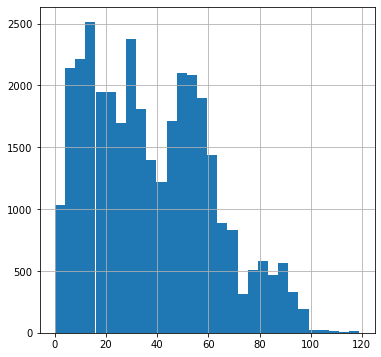

In [8]:
bridges2.Age.hist(bins=30,figsize=(6,6))

When the older bridges are excluded we also drop the historic column.

In [9]:
bridges3 = bridges2.loc[bridges2.Age < 100].drop(labels='Historic', axis=1)

**Step 3: Reduce Design and Materials Categories** 

Both materials and design include an other category but also some very small categories, with fewer bridges than the other category.

Material
Concrete    27081
Masonry        11
Other          48
Steel        6604
Timber        465
dtype: int64 

Design
Arch            139
Beam          28297
Frame            68
Movable          13
Other          1240
Slab           4330
Suspension        5
Truss           117
dtype: int64


<AxesSubplot:xlabel='Design'>

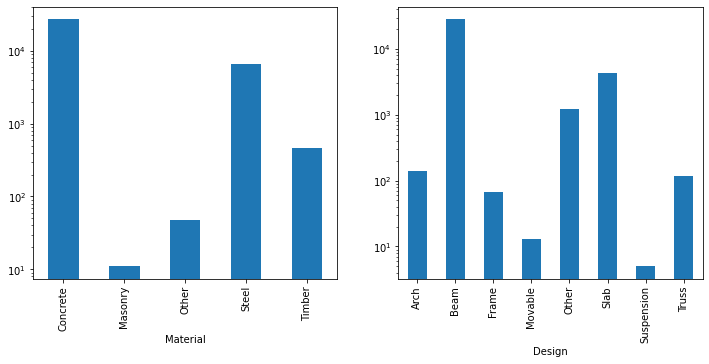

In [10]:
gbyMaterial = bridges3.groupby(by = 'Material', dropna=False)
gbyDesign = bridges3.groupby(by = 'Design', dropna=False)

print(gbyMaterial.size(), "\n")
print(gbyDesign.size())

fig, (a1, a2) = plt.subplots(1, 2, figsize = (12, 5))

gbyMaterial.size().plot(ax=a1,kind='bar',logy=True)
gbyDesign.size().plot(ax=a2,kind='bar',logy=True)

For the material, the number of `Masonry` bridges is small. For the design, the two smallest are `Movable` and `Suspension`. These categories are merged into the other category. 

In [11]:
# define functions to merge categories for Material and Design
def recodeMaterial(row):
    if row.Material == 'Masonry': return 'Other'
    return row.Material
        
def recodeDesign(row):
    if (row.Design == 'Movable') or (row.Design == 'Suspension'):
        return 'Other'
    return row.Design

# apply the function, creating a new column,
bridges4 = bridges3.assign(Material = bridges3.apply(recodeMaterial, axis=1), 
                           Design = bridges3.apply(recodeDesign, axis=1))
#bridges4

In [12]:
gbyMaterial = bridges4.groupby(by = 'Material', dropna=False)
gbyDesign = bridges4.groupby(by = 'Design', dropna=False)

print(gbyMaterial.size(), "\n")
print(gbyDesign.size())

Material
Concrete    27081
Other          59
Steel        6604
Timber        465
dtype: int64 

Design
Arch       139
Beam     28297
Frame       68
Other     1258
Slab      4330
Truss      117
dtype: int64


**Step 5** 
We create a variable representing the current condition of the bridge based on the 3 main condition variables. 
  * We get the numbers that corresponds to the category (Failed, Failing, Critical...) 
  * The condition is the sum of these numbers
  * The original condition variables are dropped

In [13]:
bridges5 = bridges4.assign(
    Condition = bridges4.Deck_rating.cat.codes + bridges4.Superstr_rating.cat.codes + 
                bridges4.Substr_rating.cat.codes).drop(labels=['Deck_rating', 'Superstr_rating', 'Substr_rating'], axis=1)
bridges5

,AverageDaily,Material,Design,Trucks_percent,Age,Condition
Structure_id,,,,,,
000021521-00101,1,Concrete,Slab,0.0,14,23
000021521-00181,1,Concrete,Slab,0.0,14,22
000021521-TMP20,100,Concrete,Beam,0.0,7,24
000021525-00012,80,Timber,Beam,0.0,69,18
000021580-00092,150,Concrete,Beam,4.0,15,23
...,...,...,...,...,...,...
DAPFORHOO000012,300,Concrete,Beam,40.0,25,21
DAPFORHOO000013,300,Concrete,Beam,40.0,19,21
DAPFORHOO000015,1200,Concrete,Beam,25.0,23,21


## Section 2: Exploratory analysis

The overall aim of this section is to understand the distribution and the relationship between the variable before fitting a regression model. We have two categorical variables and 4 numerical values. In Section 2.1 we look at the distributions of the numerical values. In Section 2.2 we the correlation of the numerical variables. Section 2.3 looks at the relationship between the target variable and the variables with the highest correlation to it. The final section, section 2.4, looks at the relationship between the categorical variables.

### Section 2.1: Distribution of the Numerical Variables
We then now have a look at the distribution of the numerical variables. It is clear that the distribution of the truck percent and the average daily use are both very skewed.

,AverageDaily,Trucks_percent,Age,Condition
count,34209.000000,34209.000000,34209.000000,34209.000000
mean,11644.223976,8.595019,37.344968,20.306528
std,24254.623237,10.351899,23.651743,1.996604
min,0.000000,0.000000,0.000000,0.000000
25%,330.000000,0.000000,17.000000,19.000000
50%,3290.000000,5.000000,34.000000,21.000000
75%,11870.000000,13.000000,54.000000,22.000000
max,543000.000000,99.000000,99.000000,27.000000


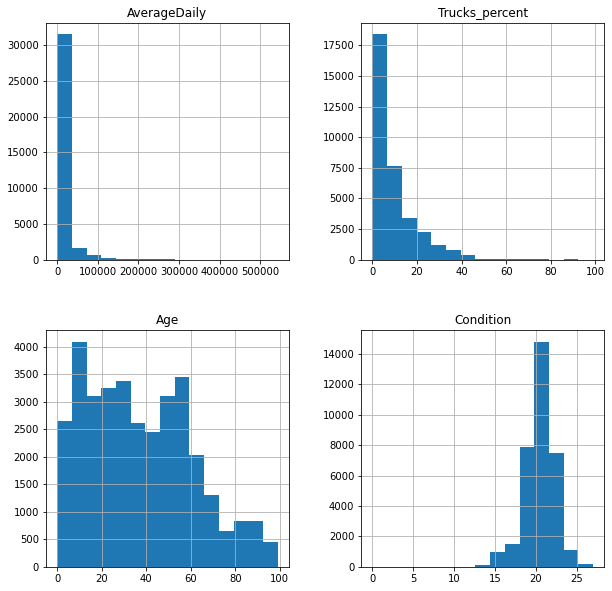

In [14]:
bridges5.hist(bins=15,figsize=(10,10))
bridges5.describe()

We can use a `boxplot` to look for outliers in the average use and percent of trucks. 

<AxesSubplot:>

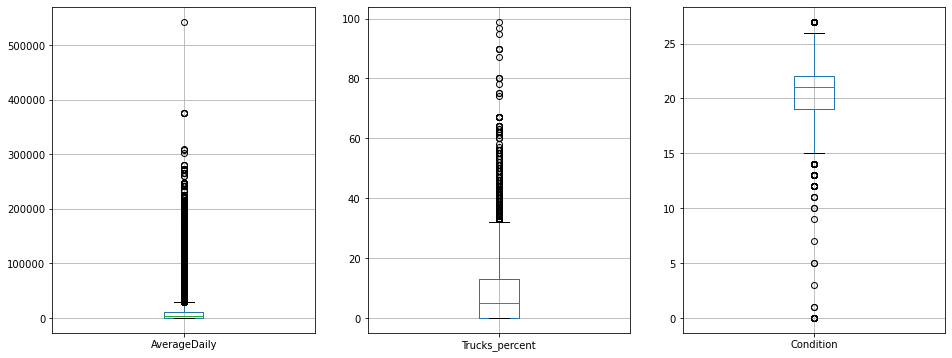

In [15]:
fig, (a1, a2, a3) = plt.subplots(1, 3, figsize = (16, 6))
bridges5.boxplot(column='AverageDaily', ax=a1)
bridges5.boxplot(column='Trucks_percent', ax= a2)
bridges5.boxplot(column='Condition', ax= a3)

**Discussion and Outliers**

1. For the average daily use we see two points that are far from the others. We can exclude the two points by choosing a threshold for average use of 350000. (A possible alternative approach would be to transform the data using a logarithm). 
2. For the percentage of truck, although also very skewed, we decide not to make any changes as the value has a limited range (being a percentage). Again a transform could be considered.
3. The mean condition is just over 20 (out of a maximum of 27); the distribution is quite symmetrical but with a tail of bridges in poor condition. We exclude these as it seems that the aim of the regression to identify bridges not so far advanced in deterioration as to be obviously failing.  


In [16]:
bridges6 = bridges5.loc[(bridges5.AverageDaily <= 350000) & (bridges5.Condition > 14)].copy()
bridges6

,AverageDaily,Material,Design,Trucks_percent,Age,Condition
Structure_id,,,,,,
000021521-00101,1,Concrete,Slab,0.0,14,23
000021521-00181,1,Concrete,Slab,0.0,14,22
000021521-TMP20,100,Concrete,Beam,0.0,7,24
000021525-00012,80,Timber,Beam,0.0,69,18
000021580-00092,150,Concrete,Beam,4.0,15,23
...,...,...,...,...,...,...
DAPFORHOO000012,300,Concrete,Beam,40.0,25,21
DAPFORHOO000013,300,Concrete,Beam,40.0,19,21
DAPFORHOO000015,1200,Concrete,Beam,25.0,23,21


In [17]:
bridges6.describe()

,AverageDaily,Trucks_percent,Age,Condition
count,34044.000000,34044.000000,34044.000000,34044.000000
mean,11626.747591,8.615762,37.247533,20.344730
std,23799.831757,10.352519,23.608791,1.902279
min,0.000000,0.000000,0.000000,15.000000
25%,350.000000,0.000000,17.000000,19.000000
50%,3320.000000,5.000000,34.000000,21.000000
75%,11910.000000,13.000000,54.000000,22.000000
max,310480.000000,99.000000,99.000000,27.000000


## Section 2.2 Correlation of Numerical Variables

We investigate the relationship between variables in the data using both the correlation matrix and the scatter plots for the numerical variables.

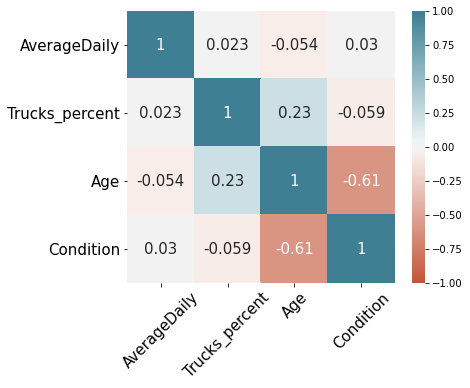

In [18]:
fig,ax = plt.subplots(1,1, figsize=(6,5))
sns.heatmap(bridges6.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)

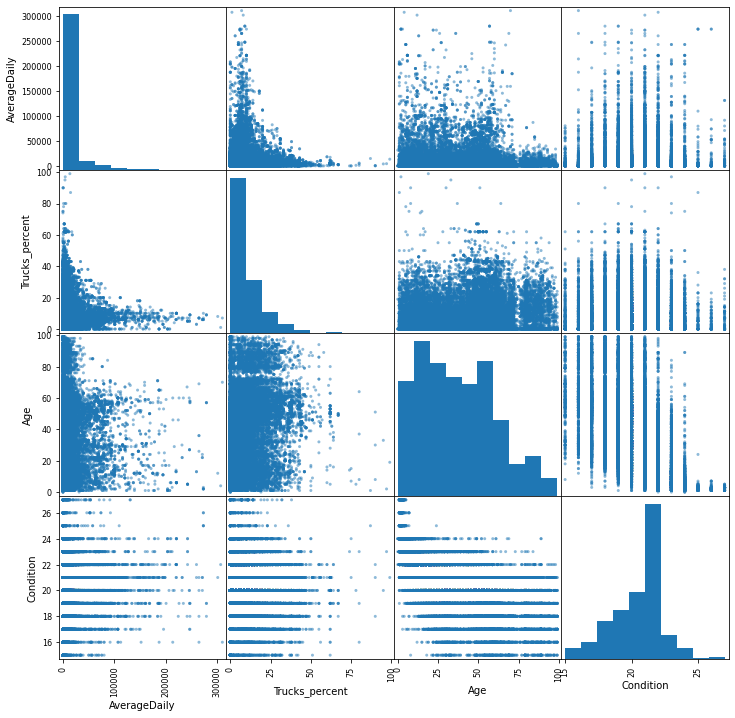

In [19]:
_a = pd.plotting.scatter_matrix(bridges6, figsize=(12,12))

**Discussion**

1. We see that age and current condition seem to be correlated, the older is the bridge the worse is its current condition. 
2. The correlations between the current condition and other predictors seem not to be very strong. The absence of a relationship between usage and condition may seem surprising at first: surely the more traffic a bridges carries the worse its condition becomes? This supposed relationship neglects repair: instead we suppose that the greater the traffic using a bridge, the more important it is to keep it in acceptable repair. 
3. The correlations between the proposed predictors are also small, suggesting that we will not have the problem of multicollinearity. 

## Section 2.3: Relationship of the Categorical Variables to the Condition Variables
We investigate the relationship between categorical variables and the current condition of the bridge and to age, since this has a strong correlation with the condition.

**Material**

Text(0.5, 0, 'Age')

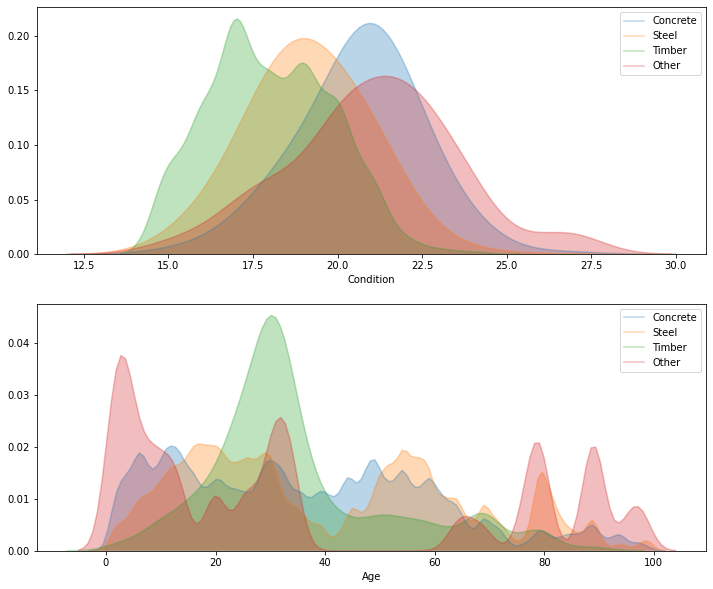

In [20]:
gbyMaterial = bridges6.groupby(by = 'Material', dropna=False)

m_concrete = gbyMaterial.get_group('Concrete')
m_steel = gbyMaterial.get_group('Steel')
m_timber = gbyMaterial.get_group('Timber')
m_other = gbyMaterial.get_group('Other')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,10))

var = 'Condition'
sns.kdeplot(data=m_concrete[var], label='Concrete', ax=ax1, alpha=0.3, shade=True, bw=1)
sns.kdeplot(data=m_steel[var], label='Steel', ax=ax1, alpha=0.3, shade=True, bw=1)
sns.kdeplot(data=m_timber[var], label='Timber', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=m_other[var], label='Other', ax=ax1, alpha=0.3, shade=True)
ax1.set_xlabel(var)

var = 'Age'
sns.kdeplot(data=m_concrete[var], label='Concrete', ax=ax2, alpha=0.3, shade=True, bw=1)
sns.kdeplot(data=m_steel[var], label='Steel', ax=ax2, alpha=0.3, shade=True, bw=1)
sns.kdeplot(data=m_timber[var], label='Timber', ax=ax2, alpha=0.3, shade=True)
sns.kdeplot(data=m_other[var], label='Other', ax=ax2, alpha=0.3, shade=True, bw=2)
ax2.set_xlabel(var)

**Discussion**

1. The conditions appears to vary with material, from timber worst, then steel, the concrete and other in best condition. However, the distributions overlap.

2. Th eage distribution should both changes in the material over time alongside periods of greater or more bridge building.

3. These variation of condition with material could be explained by ages differences, although the relationship are complex. For example, the 'other' material categories are both old and new. It is likely that quite different materials are group together in this category.


**Design**

Text(0.5, 0, 'Age')

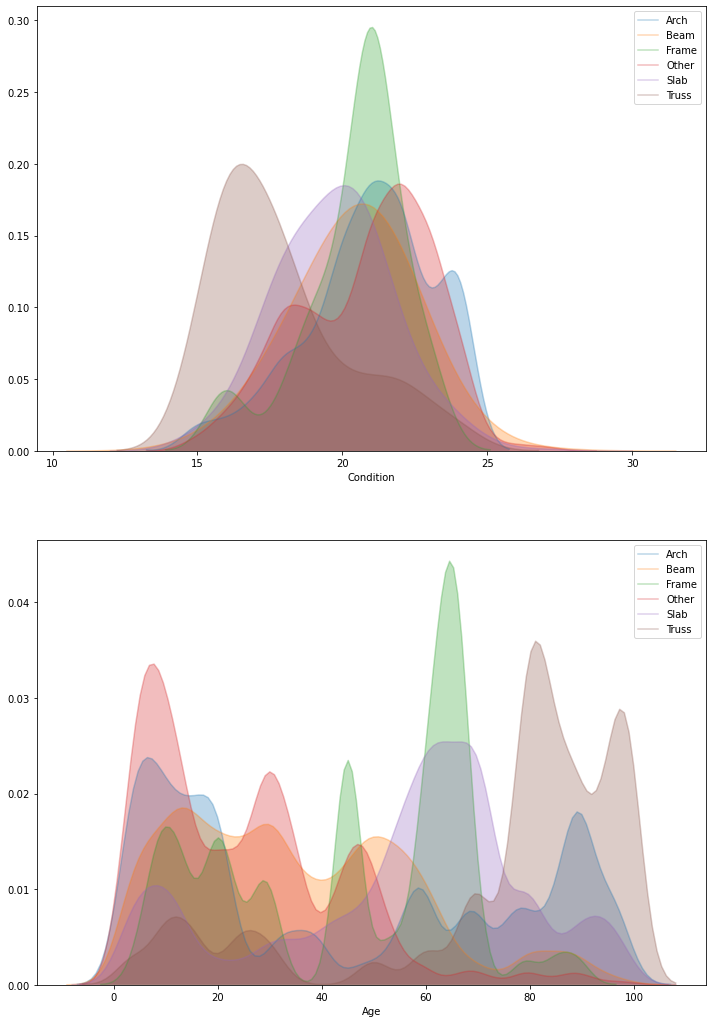

In [21]:
gbyDesign = bridges6.groupby(by = 'Design', dropna=False)

d_arch = gbyDesign.get_group('Arch')
d_beam = gbyDesign.get_group('Beam')
d_fram = gbyDesign.get_group('Frame')
d_othe = gbyDesign.get_group('Other')
d_slab = gbyDesign.get_group('Slab')
d_trus = gbyDesign.get_group('Truss')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,18))

var = 'Condition'
sns.kdeplot(data=d_arch[var], label='Arch', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=d_beam[var], label='Beam', ax=ax1, alpha=0.3, shade=True, bw=1.5)
sns.kdeplot(data=d_fram[var], label='Frame', ax=ax1, alpha=0.3, shade=True, bw=0.7)
sns.kdeplot(data=d_othe[var], label='Other', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=d_slab[var], label='Slab', ax=ax1, alpha=0.3, shade=True, bw=1)
sns.kdeplot(data=d_trus[var], label='Truss', ax=ax1, alpha=0.3, shade=True)
ax1.set_xlabel(var)

var = 'Age'
sns.kdeplot(data=d_arch[var], label='Arch', ax=ax2, alpha=0.3, shade=True, bw=3)
sns.kdeplot(data=d_beam[var], label='Beam', ax=ax2, alpha=0.3, shade=True, bw=3)
sns.kdeplot(data=d_fram[var], label='Frame', ax=ax2, alpha=0.3, shade=True, bw=2.5)
sns.kdeplot(data=d_othe[var], label='Other', ax=ax2, alpha=0.3, shade=True, bw=2.5)
sns.kdeplot(data=d_slab[var], label='Slab', ax=ax2, alpha=0.3, shade=True, bw=3)
sns.kdeplot(data=d_trus[var], label='Truss', ax=ax2, alpha=0.3, shade=True, bw=3)
ax2.set_xlabel(var)

The following code can also be used to tabulate the statistics of the groups.

In [22]:
def describeBy(groups, columns):
    for (index,grp) in groups:
        print('\nGroup', index)
        print('------------------')
        print(grp.loc[:,columns].describe())

# describeBy(gbyMaterial, ['Age', 'AverageDaily', 'Trucks_percent', 'Condition'])
# describeBy(gbyDesign, ['Age', 'AverageDaily', 'Trucks_percent', 'Condition'])

**Discussion**

1. The truss design bridges are in worse condition but they are also clearly older.
2. Arch bridges are either old or new: new approaches appear to have revived the use of this basic design. There is a small indication that the condition is better.
3. The other design category are generally newer and in slightly better condition.

## Section 2.4: Relationship between Categorical Variables

Last, we can have a look at the joint distribution of the two categorical variables in the data: Material and Design.

In [23]:
des_given_mat= pd.crosstab(bridges6.Design, [bridges6.Material], normalize='columns')
#des_given_mat

Text(0.5, 1.0, 'Design given Material')

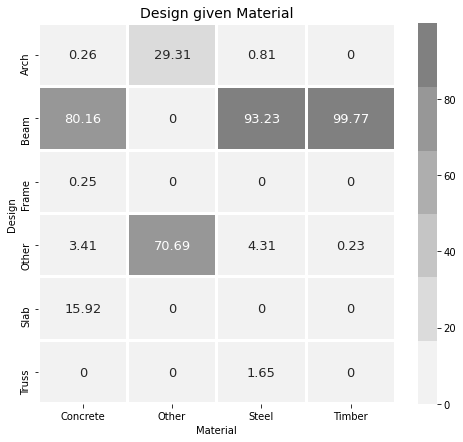

In [24]:
fig,ax = plt.subplots(1,1, figsize=(8,7))
sns.heatmap(des_given_mat.round(4)*100, cmap=sns.light_palette('grey'), linewidths = 2,
            annot=True, ax=ax, annot_kws={"size": 13}, fmt='g')
ax.set_title('Design given Material', fontsize=14)

**Discussion**

1. It is clear that the design and materials are not independent. 
2. Timber is primarily used for beam designs. 
3. Steel is used for beam, truss or other - with beam the most popular.
4. Concrete is used for most design types, except for the Truss (which is exclusively in steel). 
5. The 'other' categories in both materials and design are strongly related. 


## Section 3: Linear Regression 

In this section we construct and analyse a linear regression model with the variables age, average use, percent trucks, material or design to predict the current condition of the bridges.  

After analysing the data in Section 2 we concluded that it is reasonable to assume that there is at least some correlation between the response variables and the predictors and that the predictors are not strongly correlated between themselves. See the [helpful web page](https://data.library.virginia.edu/normality-assumption/) explaining the assumptions for regression and why normality is not a requirement.

### Section 3.1: Dummy Variables Transformation
There are two categorical variables to include in the regression analysis. To do this, we need to create dummy variables for each category of each variable using one arbitrary category as a base. Using *drop_first = True* excludes the first category making it the base category. 

In [25]:
mat_d = pd.get_dummies(bridges6.Material, drop_first = True) #Uses category 'Concrete' as a base
des_d = pd.get_dummies(bridges6.Design, drop_first = True) #Uses category 'Arch' as a base
#mat_d

### Section 3.2: Regression Fit and Coefficients

The predictor values are 'stacked' in the form required. The coefficient of determination and the parameters are printed.

Note that we have chosen NOT to standardise the predictors, though this is commonly done. [See this post for a discussion](https://stats.stackexchange.com/questions/29781/when-conducting-multiple-regression-when-should-you-center-your-predictor-varia). The variable that it would be most helpful to standard would the AverageDaily since this has such a large range (maximum 310,000 vehicles per day). 

In [26]:
y = bridges6.Condition # this is the target variable; we assue just one though more are possible
X= np.column_stack((bridges6.Age, bridges6.AverageDaily, bridges6.Trucks_percent
                    , des_d.Beam, des_d.Frame, des_d.Other, des_d.Slab, des_d.Truss
                    , mat_d.Other, mat_d.Steel, mat_d.Timber))

reg = LinearRegression().fit(X, y)

vars = ['Age', 'AverageDaily', 'Trucks_percent', 
        'BeamDesign', 'FrameDesign', 'OtherDesign', 'SlabDesign', 'TrussDesign', 
        'OtherMaterial', 'SteelMaterial', 'TimberMaterial']

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
for (v, c) in zip(vars, reg.coef_):
    print("Variable %s has coefficient %5.4f" % (v, c))

The R2 coefficient of determination is 0.469
The intercept is 23.5
Variable Age has coefficient -0.0481
Variable AverageDaily has coefficient -0.0000
Variable Trucks_percent has coefficient 0.0041
Variable BeamDesign has coefficient -1.0939
Variable FrameDesign has coefficient -0.8424
Variable OtherDesign has coefficient -1.1879
Variable SlabDesign has coefficient -1.1560
Variable TrussDesign has coefficient -0.7095
Variable OtherMaterial has coefficient 0.1758
Variable SteelMaterial has coefficient -1.3364
Variable TimberMaterial has coefficient -2.6934


In [27]:
print("Effect of Age at max value is %3.2f condition points" % (reg.coef_[0]*100))
print("Effect of AverageDaily at max value is %3.2f condition points" % (reg.coef_[1]*310480))
print("Effect of Trucks percent at max value is %3.2f condition points" % (reg.coef_[2]*99))

Effect of Age at max value is -4.81 condition points
Effect of AverageDaily at max value is -0.35 condition points
Effect of Trucks percent at max value is 0.41 condition points


**Discussion**

1. The predictors explain 46.9% of the variability in the current condition of the bridge. 
2. The factor that has more impact in this case is age. For each year the age increases, the condition score decreases by 0.048. Over the 100 age range the maximum score decrease is 4.81.
3. The daily traffic and trucks percent have much less impact. At its maximum value of 310,480 vehicle per day the score is reduce by 0.35 points. 99% trucks increases the score by 0.41 points. 
4. The coefficients for materials and design are easier to interpret as the values add to prediction when the factor is present.
5. All the design options have a negative coefficient; the default (the arch) is therefore 'best'. The design with the greatest subtraction from the condition score is 'other', followed by 'slab'.
6. Timber and steel materials have negative coefficients, subtracting 2.7 and 1.3 respectively compared to the base material which is concrete. However, the 'other' category of materials adds 0.18.

### Section 3.3: Analysis of Errors 

Next we can have a look at the distribution of the prediction errors.

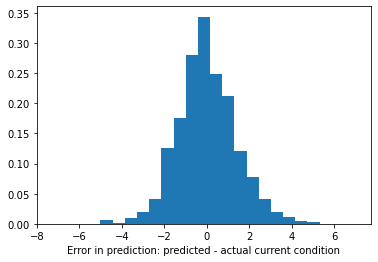

In [28]:
y_hat = reg.predict(X)

fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
a1.hist(residuals, bins=25, density=True)
_ = a1.set_xlabel('Error in prediction: predicted - actual current condition')

The distribution of the errors seems approximately normal centered at 0. We could also use QQplot to check the assumption that the errors are normally distributed. 

Below we plot the predicted versus actual current condition.

Text(0, 0.5, 'Actual Value')

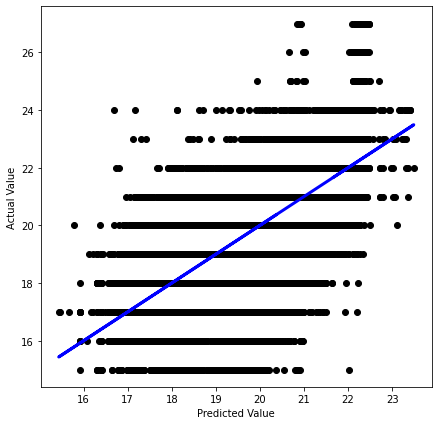

In [29]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(7,7))
a.scatter(y_hat, y,  color='black')
a.plot(y_hat, y_hat, color='blue', linewidth=3)


a.set_xlabel('Predicted Value')
a.set_ylabel('Actual Value')

Text(0, 0.5, 'Prediction error')

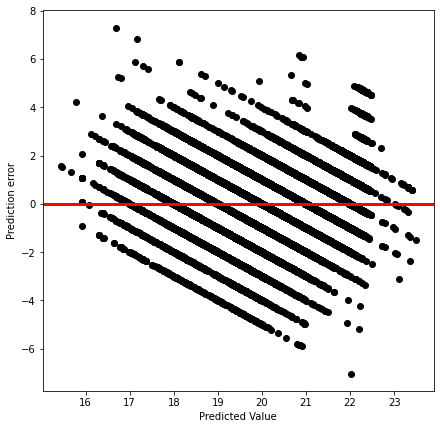

In [30]:
fig, a = plt.subplots(1,1,figsize=(7,7))
a.scatter(y_hat, (y-y_hat), color='black')
plt.axhline(y = 0, color ="red", linewidth=3)

a.set_xlabel('Predicted Value')
a.set_ylabel('Prediction error')

Ideally, this plot should show no pattern. We see again that the largest errors are related to the smallest current condition scores.

In [31]:
# The mean squared error
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.39


## Section 4: Conclusion

The objective of this analysis is to investigate which of the variables age, average use, percent trucks, material or design have more influence on the current condition of the bridges. 
* The overall condition of the bridge was represented by an equal combination of the deck condition, the substructure condition and the super structure condition. 
* The age was calculated using the date of the data and the year the bridge was built. 
* The materials and design categories were simplified to have 4 and 6 categories respectively.
* The following cases were excluded: bridges 100 or more years old, those with missing condition values, an outlier of daily average use, bridges in the worst condition (14 or lower).
* An exploratory analysis looked at the relationship between variables  
* A regression analysis predicted the condition from age, daily average, percentage of trucks, design and materials. 

The main findings of the exploratory analysis are as follows.

1. The condition distribution is quite symmetric with a mean between 20 and 21 (out of 27).
1. The predictors age, average use and percentage of trucks are not highly correlated; only age shows a high correlation with condition.
2. The materials and design are not independent with some materials not used or preferred for some designs.

The main findings of the regression analysis are as follows.

1. The regression explains a little less than 50% of the variability in condition. The RMS error is 1.4 points of the condition score.
2. Age is the most important predictor. 
3. Neither the daily average nor the percentage of trucks are important predictors: we speculate that although heavy use of a bridge accelerates deterioration, it also prioritizes repair. However, there we cannot investigate this further without data on repair. 
4. The materials and design predictors are intermediate in strength but the pattern is complex. Timber is the worst material and slab or 'other' the worst designs. However, timber is only used for beams designs (the default in design in the dummy variables used for regression) and the slab design implies the use of concrete.

Overall we conclude that the bridge condition declines with age but cannot be predicted very accurately with the proposed variables.